### Temporal Plot of Raw Data

In [2]:
import os, csv, pickle, gzip, torch, copy
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R


#========= read =========================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)
# df_files(dffile): (param df data for all subject, file pairs)
# 	sub_idx	file_idx	is_exclude	start_idx	end_idx	length	h	v	d	x	y	z
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output


spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

file_name = "0915-f18r16"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

dfpath = "data/data_feature/0216-df.csv"
dffile = pd.read_csv(dfpath, na_values=" NaN").dropna(how='all', axis=1)
dffile = dffile[['sub_idx','file_idx','length', 'h','v','d']]
# print(dffile.head)

params_df = dffile[['h','v','d']]
params_tensor = torch.tensor(params_df.values, dtype=torch.float32)
PARAMS = params_tensor.reshape(24, 144, 3)
# print(PARAMS[0])

open gzip


In [84]:
#========= temporal plot functions =========================================================================
%matplotlib notebook
%matplotlib inline
from tqdm import tqdm
from functools import partial
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib import rc
import matplotlib.cm as cm
from matplotlib.collections import LineCollection


#X for subject= [144, 18, 16]. For the latter half velocity section
#===========================================
#(HMD, lhand, rhand, index) 
#(e1, e2) **e0 was combined eye and not included 
#(efrch, efrc1, efrc2) 
#(vecprod: e1*efrch, e2*efrch, e1*efrc1, e2*efrc2)
#===========================================
def save_df_per_sub_and_combo(ffile, sfile, dffile, PARAMS):
    """
    FUNC: make 16 subject df list on velocity
    FUNC: make 36 combo df list on velocity
    """
#     #1. ====================
#     X_sub_comb_list = [] #[16][36][4]
#     for sIdx in range(16):
#         X = ffile[sIdx][0] #[144][F,18,16] X is already trimmed=============
#         pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         param = PARAMS[sIdx][pIdx]        
        
#         X_list_file = []
#         for fIdx in range(144): 
#             X_f = X[pIdx][:, 9:] #[F,9,16] 
#             X_list_file.append(X_f)
            
#         #======== package to (36 combination, 4 repeat) listlist
#         X_list_comb = [] 
#         for fIdx in range(36): #4repeats for 36 combo = 144 files
#             arr_idx = (cIdx, 36+cIdx, 72+cIdx, 108+cIdx)
#             X_comb = [X_list_file[i] for i in array_idx]
#             X_list_comb.append(X_comb)
            
#         X_sub_comb_list.append(X_list_comb)
            
    #2. ====================== 
    X_comb_sub_list = [] #[36][64, F, 9, 16]
    for cIdx in range(36):
        
        X_sub_list = []#64 = 16*4 files
        for sIdx in range(16):
            # Input for subject & pointer file index
            X_sub = ffile[sIdx][0] #[144][F,J,16]
            arr_pIdx0 = int(sfile[sIdx][cIdx]) 
            arr_pIdx1 = int(sfile[sIdx][cIdx+36]) 
            arr_pIdx2 = int(sfile[sIdx][cIdx+72]) 
            arr_pIdx3 = int(sfile[sIdx][cIdx+108])
            
            # 4 repeat files & velocity feature subset
            X_sub_list.append( X_sub[arr_pIdx0][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx1][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx2][:, 9:] )
            X_sub_list.append( X_sub[arr_pIdx3][:, 9:] )
        
        # nest & pad list[tensors]
        X_sub_list = torch.nested.nested_tensor(X_sub_list) # [64, variable F, 16]
        X_sub_list = torch.nested.to_padded_tensor(X_sub_list, 0) # [64, common F, 16]
        X_comb_sub_list.append(X_sub_list)
        
    #===========================================================    
    #Plot Average for 36 configs
    #===========================================================   
    plt.figure()
    plt.title("Task-time distribution (per combination)")
    plt.xlabel("seconds")
    plt.ylabel("linear velocity (m/s)")
    plt.xlim(0, 3)
    plt.ylim(0, 3)
    idx_to_plot = input("idx to plot")
    for cIdx in range(36):
        X_comb = X_comb_sub_list[cIdx] #[64, F, 9, 16]
        X_comb_avg = torch.mean(X_comb, 0) #[F, 9, 16]
        
        X_plot = X_comb_avg[:, int(idx_to_plot)]
        X_plot = X_plot[::12] #downsample to 120->10fps
        
        # divide by delta
        positions = X_plot[:,(3,7,11)] *120 
        rot = X_plot[:,(0,1,2, 4,5,6, 8,9,10)] *120
        
        
        frametime = 1/10
        x = torch.linspace(0, X_plot.shape[0]*frametime, X_plot.shape[0])
        X_linvel = torch.norm(positions, dim=1)
        ax = plt.plot(x, X_linvel)


def plot_tasktime_distribution(dffile):
    # https://note.nkmk.me/en/python-pandas-multiple-conditions/#select-rows-by-multiple-conditions
    """
    dffile = pd of ['sub_idx','file_idx','length', 'h','v','d']
    
    1. use sub(0-15)
    2. isolate by 36 combinations
    3. find mean avg / std for length
    """
    # ===== plot by combination ===========
    df = dffile.loc[ dffile['sub_idx']<16]
    df_combination = pd.DataFrame()
    plt.figure()
    plt.title("Task-time distribution (per target position)")
    print("#Files // Mean_l // Min_l // Max_l // STD" )
    for cIdx in range(36):
        v1, v2, v3, v4 = cIdx, 36+cIdx, 72+cIdx, 108+cIdx
        df_comb = df.loc[ (df['file_idx'] == v1) | (df['file_idx'] ==v2) | (df['file_idx'] == v3) | (df['file_idx'] == v4)]
        df_comb = df_comb.loc[df_comb['length'] > -1].reset_index(drop=True)
        col_name = 'c' + str(cIdx)
        df_comb_length = df_comb['length']/120
        # print(df_comb_length.shape[0], "//", round(df_comb_length.mean(),2), "/", round(df_comb_length.min(),2), "/", round(df_comb_length.max(),2), "/", round(df_comb_length.std(),2))

        ax = df_comb_length.plot.kde()
        ax.set_xlabel('seconds')   
        ax.set_xlim(0, 2)
    
    # ===== plot by subject ===========
    df = dffile        
    plt.figure()
    plt.title("Task-time distribution (per subject)")
    plt.xlabel()
    print("#Files // Mean_l // Min_l // Max_l // STD" )        
    for sIdx in range(24):
        df_sub = df.loc[ (df['sub_idx'] == sIdx) ]
        df_sub = df_sub.loc[df_sub['length'] > -1].reset_index(drop=True)
        df_sub_length = df_sub['length']/120
        # print(sIdx, "//", round(df_sub_length.mean(),2), "/", round(df_sub_length.min(),2), "/", round(df_sub_length.max(),2), "/", round(df_sub_length.std(),2))    
        
        ax = df_sub_length.plot.kde()
        ax.set_xlabel('seconds')
        ax.set_xlim(0, 5)
 

idx to plot 2


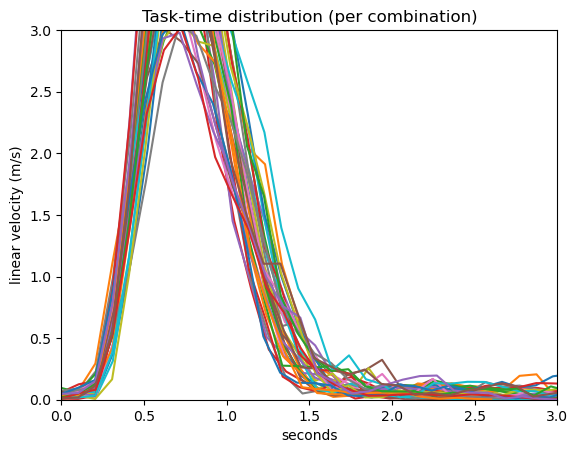

In [85]:
# calc_meta_data(dffile)
# plot_velocity_progress(ffile, sfile, PARAMS)
save_df_per_sub_and_combo(ffile, sfile, dffile, PARAMS)

In [31]:
a = torch.randn(8, 16)
p = a[:, 0:3]
b = torch.norm(p, dim=1)
print(b.shape)

torch.Size([8])


In [ ]:
# # trash
# def plot_velocity_progress(ffile, sfile, PARAMS):
#     """
#     ffile = feature file for subject
#     sfile = pointer idx file
#     PARAMS = parameter file for all sub sessions
    
#     1. For 16 subjects, divide by 36 combinations.
#     2. Results in (16*4)progression for each combinations
#     3. Find longest progression frame for each combination
#     4. Resample to wanted sampling rate
#     5. Average for each data point til the longest file frame
#     6. Plot all 36 combinations or plot for different depth, angle values.
#     7. try to find visual deviance
#     """
    
#     # =====Input Feature Index to Plot ==================
#     print( "jidx:(0,1,2,3)=(Hmd,lh,rh,rindex), (4,5,6,7,8)=(e1,e2,efrch,efrc1,efrc2), (9)=(vecprod)" )
#     print("jidx velocity:(10,11,12,13), (14,15,16,17,18), (19)")
#     jIdx = int(input("jIdx to Plot: "))
          
#     # =====START LOOP (file -> subject ==================
#     fig, (ax) = plt.subplots(1,1)
#     fig.set_size_inches(8,8)
#     plt.title("Prog-MiliSeconds")
    
#     plt.figure()
#     plt.title("Progression per subject")
    
#     for sIdx in tqdm(range(16)):
#         # pIdx = int(sfile[sIdx][fIdx]) #pointer idx
#         # param = PARAMS[sIdx][pIdx]
        
#         #====== X, HMD, and selected Feature ========
#         X = ffile[sIdx][0] #[144][F,J,R]
#         HMD = ffile[sIdx][4] #[144][non-trim F,4,4]
#         # HMD & HMD VEL
#         HMD_vel = calc_hmd_delta_ts(HMD)
        
#         # TRIM 0th frame to match velocity and set endframe
#         TrimHmd = [ hmd[1:x.shape[0]+1] for hmd in HMD for x in X ]
#         TrimHmd_vel = [ hmd_vel[1:x.shape[0]+1] for hmd_vel in HMD_vel for x in X ]
#         F = [ x[:,None, jIdx] for x in X] #[144][F,1,R] for (jIdx)th feature
#         F = convert_9tf_to_12tf(F)
        
#         #========PER PARAM===================
        
#     for cIdx in tqdm(range(36)):
#         arr_idx = np.array([cIdx, 36+cIdx, 72+cIdx, 108+cIdx], dtype=np.int16)
#         sub_range = 16
#         ffile_param = [ffile[i] for i in range(sub_range)] # [16][9]<-9 chunks of list

        
#         X_param = [ffile_param[16][0][i] for i in arr_idx]
#         HMD_param = [ffile_param[16][4][i] for i in arr_idx]
#         print(len(X_param))
#         print(len(X_param[0]))
        
        
#         max((tensor1, tensor2), key=len)
        
        
        
# #         HMD = [ffile[i][4] for i in sub_range]
        
# #         print(len(X))
# #         print(X[0].shape)
        
# #         X_comb = [X[i] for i in arr_idx]
# #         HMD_comb = [HMD[i] for i in arr_idx]
# #         print(len(HMD_comb))
# #         print(HMD_comb[0].shape)



                      
    

# def convert_9tf_to_12tf(input_list):
#     """
#     input : list of tensors = [#files][f,j,9]
#     output: list of tensors = [#files][f,j,12]
#     rx =(0,1,2), ry=(3,4,5), p(6,7,8)
#     back to
#     [ 0 1 2 6 ] --> [ 0 1 2 3 ]
#     [ 3 4 5 7 ] --> [ 4 5 6 7 ]
#     [ - - - 8 ] --> [ 8 9 10 11]
#     [ 0 0 0 1 ] --> [ 0 0 0 1]
#     """
#     j = input_list[0].shape[1]
#     output_list = []
#     for input_tensor in input_list :
#         rx = input_tensor[:, :, 0:3]
#         ry = input_tensor[:, :, 3:6]
#         rz = torch.cross(rx, ry, dim=2)
#         p = input_tensor[:, :, 6:9]

#         frames = input_tensor.shape[0]
#         t = torch.stack([torch.eye(4) for f in range(frames)]).unsqueeze(1).expand(-1,j,-1,-1) #[f,j,4,4]
#         t[:,:,0,0:3] = rx
#         t[:,:,1,0:3] = ry
#         t[:,:,2,0:3] = rz
#         t[:,:,:3,3] = p
        
#         output_list.append(t)
#     return output_list
    
    
# def calc_hmd_delta_ts(HMD):
#     """
#     input : list of tensors = [#files][f,4,4]
#     output: list of tensors = [#files][f-1,4,4]
#     """
#     HMD_vel = []
#     for hmd in HMD:
#         frames = hmd.shape[0]
#         hmd_vel = copy.deepcopy(hmd)
#         for f in range(frames-1):
#             hmd_vel[f] = torch.matmul(hmd[f+1], torch.linalg.inv(hmd[f]))
#         HMD_vel.append(hmd_vel)
#     return HMD_vel  